In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import LabelEncoder

drive.mount('/content/drive')

products_df = pd.read_csv('products.csv')
transactions_df =  pd.read_csv('/content/drive/My Drive/transactions.csv')

user_product = transactions_df.groupby(['user_id', 'product_id'])['product_id'].count()
user = transactions_df.groupby(['user_id'])['product_id'].count()

g = pd.DataFrame(user_product.div(user, level='user_id')).add_suffix('_count').reset_index()

le = LabelEncoder()
g['user_id_num'] = le.fit_transform(g['user_id'])
g['product_id_num'] = le.fit_transform(g['product_id'])

Mounted at /content/drive


In [2]:
g[['user_id', 'user_id_num']].drop_duplicates().to_csv('users_meta.csv')
g[['product_id', 'product_id_num']].drop_duplicates().to_csv('products_meta.csv')
g[['user_id', 'user_id_num']].drop_duplicates()

,user_id,user_id_num
0,1,0
18,2,1
120,3,2
153,7,3
221,13,4
...,...,...
9458497,206202,99995
9458560,206206,99996
9458710,206207,99997
9458802,206208,99998


In [6]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, concatenate, Dropout, Dense, dot, BatchNormalization, Add
from keras.optimizers import Adam
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot

#строим модель NCF (neural collaborative filtering) paper: https://arxiv.org/pdf/1708.05031.pdf

num_users = len(g.user_id_num.unique())
num_product = len(g.product_id_num.unique())

latent_dim = 10

product_input = Input(shape=[1],name='product-input')
user_input = Input(shape=[1], name='user-input')

product_embedding_mlp = Embedding(num_product + 1, latent_dim, name='product-embedding-mlp')(product_input)
product_vec_mlp = Flatten(name='flatten-product-mlp')(product_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

product_embedding_mf = Embedding(num_product + 1, latent_dim, name='product-embedding-mf')(product_input)
product_vec_mf = Flatten(name='flatten-product-mf')(product_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

concat = concatenate([product_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = dot([product_vec_mf, user_vec_mf], normalize = False, axes = -1, name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

result = Dense(1, name='result', activation='sigmoid')(combine_mlp_mf)

model = Model([user_input, product_input], result)
model.compile(optimizer=Adam(lr=0.0001), loss='mean_absolute_error')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product-input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
product-embedding-mlp (Embeddin (None, 1, 10)        494660      product-input[0][0]              
__________________________________________________________________________________________________
user-embedding-mlp (Embedding)  (None, 1, 10)        1000010     user-input[0][0]                 
____________________________________________________________________________________________

Epoch 1/30
221/221 [==============================] - 15s 62ms/step - loss: 0.4936 - val_loss: 0.4125
Epoch 2/30
221/221 [==============================] - 13s 60ms/step - loss: 0.1995 - val_loss: 0.1861
Epoch 3/30
221/221 [==============================] - 13s 61ms/step - loss: 0.0810 - val_loss: 0.0429
Epoch 4/30
221/221 [==============================] - 13s 59ms/step - loss: 0.0364 - val_loss: 0.0147
Epoch 5/30
221/221 [==============================] - 14s 61ms/step - loss: 0.0205 - val_loss: 0.0097
Epoch 6/30
221/221 [==============================] - 13s 60ms/step - loss: 0.0142 - val_loss: 0.0083
Epoch 7/30
221/221 [==============================] - 14s 61ms/step - loss: 0.0114 - val_loss: 0.0078
Epoch 8/30
221/221 [==============================] - 13s 61ms/step - loss: 0.0101 - val_loss: 0.0078
Epoch 9/30
221/221 [==============================] - 13s 61ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 10/30
221/221 [==============================] - 13s 60ms/step - loss: 0.009

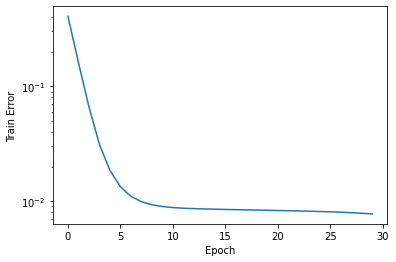

0.008877970901838214

In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

X_train, X_test = train_test_split(g,test_size=0.3,random_state=42)

history = model.fit([X_train.user_id_num, X_train.product_id_num], 
                     X_train.product_id_count, 
                     batch_size = 30000,
                    validation_data = ([X_train.user_id_num, X_train.product_id_num], 
                     X_train.product_id_count),
                     epochs=30)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([X_test.user_id_num, X_test.product_id_num]), decimals=2)
y_true = X_test.product_id_count
mean_absolute_error(y_true, y_hat)

In [8]:
model.save('ncf.h5')